# Function Approximation
Train a Multilayer Perceptron to approximate the function $y = e^x - \sin(2 \pi x)$ on the interval [-2, 2]. It does so by generating 100 targets using this function on 100 equally spaced points on such interval, and then fitting the MLP to this data using Batch Gradient Descent via backpropagation to minimize a Mean Square Error performance index. The MLP contains 2 layers, a sigmoid hidden transfer function, 10 hidden neurons and 1 output neuron with an identity output function. That is, $S^1 = 10$, $S^2 = 1$ and $R=1$. The last two are set by the problem. 

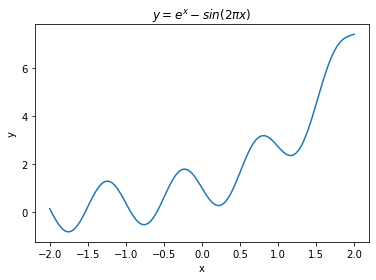

In [2]:
import numpy as np
import matplotlib.pyplot as plt
p = np.linspace(-2, 2, 100)  # (100,)
t = np.exp(p) - np.sin(2*np.pi*p)  # (100,)
plt.title("$y = e^x - sin(2 \\pi x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(p, t)
plt.show()
plt.close()

## Keras

Using TensorFlow backend.


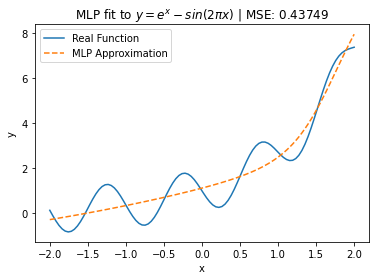

In [3]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD


# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
# It is always good practice to set the hyper-parameters at the beginning of the script
# And even better to define a params class if the script is long and complex
LR = 0.1
N_NEURONS = 10
N_EPOCHS = 5000

# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Gets the input interval and the targets
p = np.linspace(-2, 2, 100)  # (100,)
t = np.exp(p) - np.sin(2*np.pi*p)  # (100,)

# %% -------------------------------------- Training Prep --------------------------------------------------------------
# Defines the model
model = Sequential([
    Dense(N_NEURONS, input_dim=1),  # Linear layer that maps 1 input dim to N_NEURONS hidden dim
    Activation("sigmoid"),  # Sigmoid hidden transfer function
    Dense(1)  # Maps N_NEURONS hidden dim to 1 output dim
])
# Prepares a Stochastic Gradient Descent optimizer and a Mean Squared Error performance index
model.compile(optimizer=SGD(lr=LR), loss="mean_squared_error")

# %% -------------------------------------- Training Loop --------------------------------------------------------------
# Trains the model. We use full Batch GD.
# The batch size defines the number of samples that will be propagated through the network.
train_hist = model.fit(p, t, epochs=N_EPOCHS, batch_size=len(p), verbose=0)

# %% -------------------------------------- Check Approx ---------------------------------------------------------------
# Visually shows the approximation obtained by the MLP
plt.title("MLP fit to $y = e^x - sin(2 \\pi x)$ | MSE: {:.5f}".format(train_hist.history["loss"][-1]))
plt.xlabel("x")
plt.ylabel("y")
plt.plot(p, t, label="Real Function")
plt.plot(p, model.predict(p), linestyle="dashed", label="MLP Approximation")
plt.legend()
plt.show()

## TensorFlow


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0 | Loss 5.64912
Epoch 1000 | Loss 0.44686
Epoch 2000 | Loss 0.43274
Epoch 3000 | Loss 0.42612
Epoch 4000 | Loss 0.41998


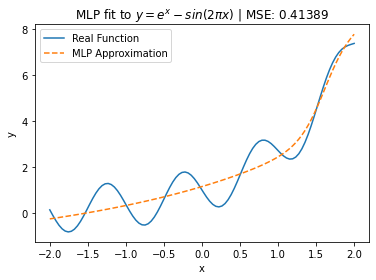

In [4]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import tensorflow as tf

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
# It is always good practice to set the hyper-parameters at the beginning of the script
# And even better to define a params class if the script is long and complex
LR = 2.5e-1
N_NEURONS = 10
N_EPOCHS = 5000
PRINT_LOSS_EVERY = 1000


# %% -------------------------------------- MLP Class ------------------------------------------------------------------
# Defines model class. Inherits from tf.keras.Model to get all useful methods and make the class compatible with tf
class MLP(tf.keras.Model):
    """ MLP with 2 layers, sigmoid transfer function and hidden_dim neurons on the hidden layer"""
    def __init__(self, hidden_dim):
        super(MLP, self).__init__()  # Initializes tf.keras.Model
        # Linear Layer that maps input (n_examples, 1) to hidden_dim (number of neurons)
        self.linear1 = tf.keras.layers.Dense(hidden_dim, input_shape=(1,))
        self.act1 = tf.nn.sigmoid  # Hidden transfer function
        # Linear Layer that maps hidden_dim to output (n_examples, 1), i.e, 1 neuron
        self.linear2 = tf.keras.layers.Dense(1)

    # Calling this method "call" will make it possible to go forward by just calling model(x) (see below)
    def call(self, x):
        # Just a sequential pass to go through the 2 layers
        return self.linear2(self.act1(self.linear1(x)))


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Gets the input interval and the targets
p = np.linspace(-2, 2, 100)  # (100,)
t = np.exp(p) - np.sin(2*np.pi*p)  # (100,)
# Converts to Tensors and reshapes to suitable shape (n_examples, 1)
p = tf.reshape(tf.convert_to_tensor(p), (-1, 1))
t = tf.reshape(tf.convert_to_tensor(t), (-1, 1))

# %% -------------------------------------- Training Prep --------------------------------------------------------------
# Initializes model
model = MLP(N_NEURONS)
# Initializes a Gradient Descent Optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
# Initializes a Mean Square Error performance index
criterion = tf.keras.losses.MeanSquaredError()

# %% -------------------------------------- Training Loop --------------------------------------------------------------
# Starts the training loop
for epoch in range(N_EPOCHS):
    # All operations using tf.Variables (the parameters of the model) are recorded in the Computational Graph
    with tf.GradientTape() as tape:
        t_pred = model(p)
        loss = criterion(t, t_pred)
    # Computes the gradients using the recorded operations (i.e, goes backwards through the Computational Graph)
    gradients = tape.gradient(loss, model.trainable_variables)
    # Updates the parameters
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Checks the training process
    if epoch % PRINT_LOSS_EVERY == 0:
        print("Epoch {} | Loss {:.5f}".format(epoch, tf.reduce_mean(loss).numpy()))

# %% -------------------------------------- Check Approx ---------------------------------------------------------------
# Visually shows the approximation obtained by the MLP
plt.title("MLP fit to $y = e^x - sin(2 \\pi x)$ | MSE: {:.5f}".format(tf.reduce_mean(loss).numpy()))
plt.xlabel("x")
plt.ylabel("y")
plt.plot(p.numpy(), t.numpy(), label="Real Function")
plt.plot(p.numpy(), t_pred.numpy(), linestyle="dashed", label="MLP Approximation")
plt.legend()
plt.show()

## PyTorch

Epoch 0 | Loss 7.31553
Epoch 1000 | Loss 0.44286
Epoch 2000 | Loss 0.44098
Epoch 3000 | Loss 0.43894
Epoch 4000 | Loss 0.43331


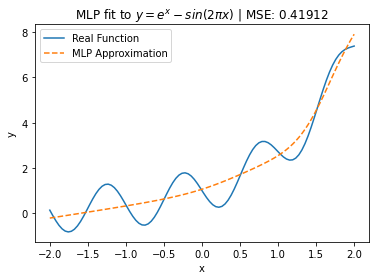

In [5]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import torch
import torch.nn as nn


# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
# It is always good practice to set the hyper-parameters at the beginning of the script
# And even better to define a params class if the script is long and complex
LR = 2.5e-1
N_NEURONS = 10
N_EPOCHS = 5000
PRINT_LOSS_EVERY = 1000


# %% -------------------------------------- MLP Class ------------------------------------------------------------------
# Defines model class. Inherits from nn.Module to get all useful methods and make the class compatible with PyTorch
class MLP(nn.Module):
    """ MLP with 2 layers, sigmoid transfer function and hidden_dim neurons on the hidden layer"""
    def __init__(self, hidden_dim):
        super(MLP, self).__init__()  # Initializes nn.Module
        # Linear Layer that maps input (n_examples, 1) to hidden_dim (number of neurons)
        self.linear1 = nn.Linear(1, hidden_dim)
        self.act1 = torch.sigmoid  # Hidden transfer function
        # Linear Layer that maps hidden_dim to output (n_examples, 1), i.e, 1 neuron
        self.linear2 = nn.Linear(hidden_dim, 1)

    # Calling this method "forward" will make it possible to go forward by just calling model(x) (see below)
    def forward(self, x):
        # Just a sequential pass to go through the 2 layers
        return self.linear2(self.act1(self.linear1(x)))


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Gets the input interval and the targets
p = np.linspace(-2, 2, 100)  # (100,)
t = np.exp(p) - np.sin(2*np.pi*p)  # (100,)
# Converts to Tensors and reshapes to suitable shape (n_examples, 1)
# requires_grad=True on the input so that the gradients are computed when calling loss.backward()
# i.e, so that all the operations performed on p and on their outputs are made part of the Computational Graph
p = torch.Tensor(p).reshape(-1, 1)
p.requires_grad = True
t = torch.Tensor(t).reshape(-1, 1)

# %% -------------------------------------- Training Prep --------------------------------------------------------------
# Initializes model and moves it to GPU if available
model = MLP(N_NEURONS)
# Initializes a Gradient Descent Optimizer with default hyper-parameters
# We pass the model.parameters() generator so that all the model's parameters are updated
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# Initializes a Mean Square Error performance index
criterion = nn.MSELoss()

# %% -------------------------------------- Training Loop --------------------------------------------------------------
# Starts the training loop
for epoch in range(N_EPOCHS):
    # Sets the gradients stored on the .grad attribute of each parameter from the previous iteration to 0
    optimizer.zero_grad()  # It is good practice to do it right before going forward on any model
    # Goes forward (doing full batch here), notice we don't need to do model.forward(p)
    t_pred = model(p)
    # Computes the mse
    loss = criterion(t, t_pred)
    # Goes backwards (computes all the gradients of the mse w.r.t the parameters
    # starting from the output layer all the way to the input layer)
    loss.backward()
    # Updates all the parameters using the gradients which were just computed
    optimizer.step()
    # Checks the training process
    if epoch % PRINT_LOSS_EVERY == 0:
        print("Epoch {} | Loss {:.5f}".format(epoch, loss.item()))

# %% -------------------------------------- Check Approx ---------------------------------------------------------------
# Visually shows the approximation obtained by the MLP
plt.title("MLP fit to $y = e^x - sin(2 \\pi x)$ | MSE: {:.5f}".format(loss.item()))
plt.xlabel("x")
plt.ylabel("y")
# .detach() to take the Tensors out of the computational graph
# .numpy() to convert the Tensors to NumPy arrays
plt.plot(p.detach().numpy(), t.numpy(), label="Real Function")
plt.plot(p.detach().numpy(), t_pred.detach().numpy(), linestyle="dashed", label="MLP Approximation")
plt.legend()
plt.show()

# Exercise: Approximate a 3D Function using a MLP

In [6]:
# %% -------------------------------------------------------------------------------------------------------------------

# -------------------------------------
# Approximate a 3D Function using a MLP
# -------------------------------------

# 1. Define the function y = x1**2 - x2**2 you will train the MLP to approximate. A 3D plot can be found at:
# # http://www.livephysics.com/tools/mathematical-tools/online-3-d-function-grapher/

# 2. Define a helper function to plot the real function and the MLP approximation. Hint:
# from mpl_toolkits.mplot3d import Axes3D, use ax.contour3D on 3 inputs with shapes (sqrt(n_examples), sqrt(n_examples))
# You may do 3. first to get the data and figure out why the shapes are like this

# 3. Generate the data to train the network using the function you defined in 1. Hint:
# Use np.meshgrid() and then reshape the input to (n_examples, 2) and the target to (n_examples, 1)

# 4. Define a MLP to approximate this function using the data you just generated.
# Play with the number of layers, neurons and hidden activation functions (tanh, ReLu, etc.)

# 5. Use Adam or another optimizer and train the network. Find an appropriate learning rate and number of epochs.

# 6. Use the function you defined in 2. to visualize how well your MLP fits the original function

# %% -------------------------------------------------------------------------------------------------------------------

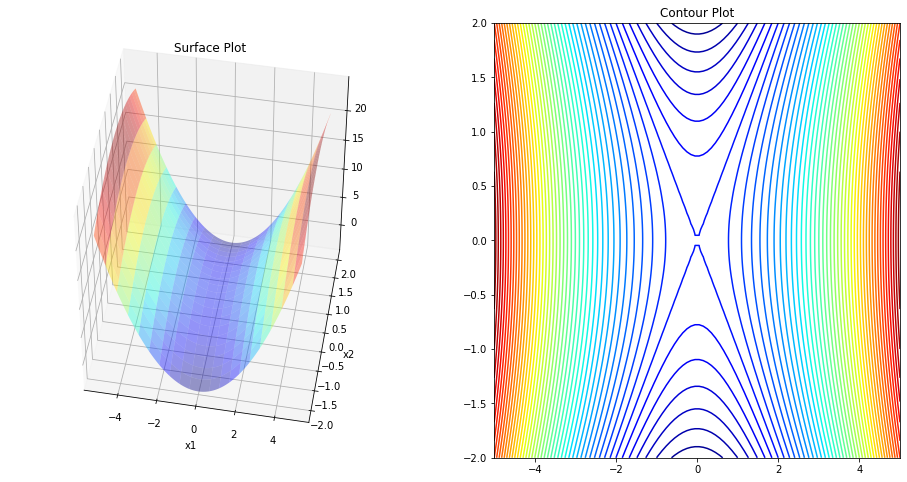

In [7]:
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1, x2)
Y = X1 ** 2 - X2 ** 2

def helper_function(X1, X2, Y):
    fig = plt.figure(figsize=(16, 8))

    # Surface plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(X1, X2, Y, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')

    ax.view_init(45, 280)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title("Surface Plot")

    # Contour plot
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(X1, X2, Y, 50, cmap='jet')
    ax.set_title("Contour Plot")

    # Plotting the iterations and intermediate values
    plt.show()
    plt.close()


helper_function(X1, X2, Y)